In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import random
import matplotlib

from matplotlib import rc
from matplotlib.patches import Ellipse
from scipy import stats

rc('text', usetex=False)
rc('font', family='freesans')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

## Get list of targets

In [8]:
targets = pd.read_csv('https://predictioncenter.org/casp14/targetlist.cgi?type=csv', sep = ';', error_bad_lines = False)
targets

,Target,Type,Res,Oligo.State,Entry Date,Server Exp.,QA Exp.,Human Exp.,Cancellation Date,Description
0,T1024,All groups,408,A1,2020-05-18,2020-05-21,m1:2020-05-25 m2:2020-05-27,2020-06-08,-,LmrP 6t1z
1,T1025,Server only,268,A1,2020-05-19,2020-05-22,m1:2020-05-26 m2:2020-05-28,2020-06-09,-,AtmM 6uv6
2,T1026,All groups,172,A1,2020-05-19,2020-05-22,m1:2020-05-26 m2:2020-05-28,2020-06-09,-,FBNSV 6s44
3,T1027,All groups,168,A1,2020-05-20,2020-05-23,m1:2020-05-27 m2:2020-05-29,2020-06-10,-,GLuc 7d2o
4,T1028,Server only,316,A1,2020-05-21,2020-05-24,m1:2020-05-28 m2:2020-05-30,2020-06-11,-,CalU17 6vqp
...,...,...,...,...,...,...,...,...,...,...
147,R1056x1,Refinement,-,-,2020-08-19,2020-08-22,-,2020-09-09,-,M23 peptidase Extended time refinement Extend...
148,R1068x1,Refinement,-,-,2020-08-20,2020-08-23,-,2020-09-10,-,LmazxJ3-JDBD Extended time refinement Extende...
149,R1074x2,Refinement,-,-,2020-08-21,2020-08-24,-,2020-09-11,-,Bd0675 Extended time refinement Extended time...
150,N1088,Assisted,-,-,2020-08-25,2020-08-28,-,2020-09-14,-,MipA


In [9]:
cancelled_targets = []
for index, row in targets.iterrows():
    if 'canceled' in row.Description or 'Canceled' in row.Description:
        cancelled_targets.append(row.Target)


# Load tables

In [10]:
def load_casp_zscore_table(target_casp, cancelled_targets, mode = None, domains_only = False, target_difficulty_file = 'target_difficulty_from_Andryi.txt'):
    
    if mode is not None:
        table = 'CASP{}_templates_table.csv'.format(target_casp, target_casp)
    else:
        table = 'CASP{}_Zscores_table.csv'.format(target_casp, target_casp)

    df = pd.read_csv(table, sep='\t').reset_index(drop=True)
    
    if domains_only:
        # remove the multidomain lines
        df = df[df.Target.str.contains("-D")]

    # remove the NaN models
    df = df[df['Model'].notna()]
    
    # add model ranking based on group
    if mode is None:            
        df['Model_GR_rank'] = [int(model.split('_')[-1].split('-')[0]) if model != 'Starting' else 0 for model in df.Model]
    else:
        # for the template tables, add as the group either that they are template, or the real structure
        df['GR#'] = ['TMP' if type(i) == str else 'REAL' for i in df.pdb]
                
    #df['Input_target'] = [target.replace('R', 'T') for target in df.Target]
    
    # exclude the cancelled targets    
    df = df[~df['Target'].isin(cancelled_targets)]
    df = df[df['Target'].notna()]

    if mode is None:
        df = fix_target_difficulties(df, target_casp, target_difficulty_file = target_difficulty_file)

    return df

def fix_target_difficulties(df, target_casp, target_difficulty_file = 'target_difficulty_from_Andryi.txt'):
    
    difficulties = pd.read_csv(target_difficulty_file, sep = '\t')
    difficulties['Target'] = ['{}-D1'.format(i.strip()) if '-' not in i else i.strip() for i in difficulties['Target']]
    
    for target in set(df.Target):
        tmp = df.loc[df.Target == target]        
        difficulty = difficulties.loc[(difficulties.Target == target) & (difficulties.CASP_id == int(target_casp))]['Rank all']
        if len(difficulty) == 0:
            difficulty = np.nan
        else:
            difficulty = float(difficulty)

        df.loc[df['Target'] == target, 'Target_difficulty'] = difficulty
    
    return df

In [11]:
target_casp = '14'
domains_only = True
do_null = True

if domains_only:
    figures_folder = 'CASP{}/highres_figs_EXCLUDING_MULTIDOMAINS_MR'.format(target_casp)
else:
    figures_folder = 'CASP{}/highres_figs_MR'.format(target_casp)

if not do_null:
    figures_folder = '{}_NO_NULL'.format(figures_folder)
    
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)

df = load_casp_zscore_table(target_casp, cancelled_targets, domains_only = domains_only)
df_templates = load_casp_zscore_table(target_casp, cancelled_targets, domains_only = domains_only, mode = 'template')

# START PLOTTING

In [7]:
# rename the columns of the templates table
new_names = []
for col in df_templates.columns:
    if '_GD' in col:
        col = col.replace('Template_', '')
    elif 'Template' in col and '_score' not in col:
        col = col.replace('Template', 'Model')
    new_names.append(col)
df_templates.columns = new_names

df_templates = df_templates.set_index('Model')
df_templates

,HitNo,pdb,pdb_release_date,pdb_method,prob,Eval,Query_interval,Model_interval,Target_coverage,Template_score,...,TFZeq_Original,Rms_Original,LLG_B_from_rms,TFZeq_B_from_rms,Rms_B_from_rms,LLG_const_B,TFZeq_const_B,Rms_const_B,Target,GR#
Model,,,,,,,,,,,,,,,,,,,,,
3WDO_A_9-187,4.0,3WDO_A,20130807.0,x-ray,99.5,1.700000e-18,"[5, 187]","[7, 185]",94.300518,96.900259,...,25.260093,1.528039,854.887328,25.260093,1.528039,854.887328,25.260093,1.528039,T1024-D1,TMP
4IKV_A_22-207,5.0,4IKV_A,20130710.0,x-ray,99.5,2.000000e-18,"[7, 186]","[22, 207]",92.746114,96.123057,...,23.050207,1.990742,742.314979,23.050207,1.990742,742.314979,23.050207,1.990742,T1024-D1,TMP
4IKW_A_22-207,6.0,4IKW_A,20130710.0,x-ray,99.5,2.000000e-18,"[7, 186]","[22, 207]",92.746114,96.123057,...,23.426117,1.916099,754.504712,23.426117,1.916099,754.504712,23.426117,1.916099,T1024-D1,TMP
4LDS_B_12-180,7.0,4LDS_B,20131016.0,x-ray,99.5,2.200000e-18,"[13, 184]","[12, 180]",88.601036,94.050518,...,22.323670,1.992701,728.875830,22.323670,1.992701,728.875830,22.323670,1.992701,T1024-D1,TMP
4ZP0_A_19-194,2.0,4ZP0_A,20150819.0,x-ray,99.6,1.600000e-18,"[10, 188]","[11, 186]",92.227979,95.913990,...,22.697761,1.865619,761.570742,22.697761,1.865619,761.570742,22.697761,1.865619,T1024-D1,TMP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
null_model,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.500000,0.000000,0.000000,57.340000,0.379889,0.000000,0.500000,T1087-D1,REAL
T1090-D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,54.339797,0.233156,0.000000,0.000000,19.710000,7994.004417,51.588766,0.311306,T1090-D1,REAL
null_model,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.500000,0.000000,0.000000,63.230000,0.064526,0.000000,0.500000,T1090-D1,REAL


## 2. Molecular replacement usability analysis

How useful are the models?

This was evaluated by checking how useful they would be for molecular replacement, and were compared with the top available templates.

### ***This analysis was carried out***:
 - with all models submitted by the groups and ignored refined models!
 - scores were calculated accounting for only #1 methods  
 - but only groups that submitted models for at least 2/3 targets were ranked

In [8]:
df_mr = df.groupby(['GR#']).filter(lambda s: s['GR#'].count()>=1)

# df_mr = df_mr[(df_mr.Model.str.startswith('T'))]
df_mr = df_mr.set_index('Model')
df_mr = df_mr.dropna(subset=[i for i in df_mr.columns if 'LLG' in i], how='all')

all_targets = sorted(list(set(list(df_mr.Target))))
all_groups = sorted(list(set(list(df_mr['GR#']))))

In [9]:
len(all_targets)

54

In [10]:
df_mr[[i for i in df_mr.columns if 'LLG' in i]]

,LLG_Original,LLG_B_from_rms,LLG_const_B,Z_LLG_Original,Z_LLG_B_from_rms,Z_LLG_const_B
Model,,,,,,
R1030-D2TS003_1,714.892102,715.537718,714.884857,0.000000,0.000000,0.000000
R1030-D2TS013_1,864.123424,992.225609,861.309564,1.638389,2.265308,2.111737
R1030-D2TS013_2,912.994200,1053.955068,907.780192,2.264045,2.845995,2.859437
R1030-D2TS013_3,933.953193,1150.955046,927.928122,2.532368,3.758471,3.183612
R1030-D2TS013_4,895.020264,1111.289425,890.795834,2.033938,3.385338,2.586163
...,...,...,...,...,...,...
T1101TS498_1-D2,266.257684,277.133951,264.768273,0.156819,0.212296,0.158489
T1101TS498_2-D2,218.987157,244.966192,218.980729,0.000000,0.064946,0.000000
T1101TS498_3-D2,244.332060,248.075215,243.270098,0.009145,0.079187,0.009326


In [12]:
removed_targets = [i for i in all_targets if i not in list(set(list(df_mr.Target)))]
removed_targets

[]

In [22]:
def get_median(curr_y, mad = 3, iteration = 0, prev_median = 0, stop_at = 0):
    
#     curr_median = np.median(curr_y)
#     curr_mad = stats.median_absolute_deviation(np.array(curr_y), scale='normal')
    
    curr_median = np.mean([i for i in curr_y if not np.isnan(i)])
    curr_mad = np.std([i for i in curr_y if not np.isnan(i)])
    
    if abs(prev_median-curr_median)/prev_median > stop_at:
        curr_y = [y for y in curr_y if y >= curr_median-mad*curr_mad]
        curr_median, iteration = get_median(curr_y, mad = mad, iteration = iteration+1, prev_median = curr_median, stop_at = stop_at)
    
    return curr_median, curr_mad 
    

def fit_median_model(df, x, y, x_lims = [0, 100], mad = 1, bins = 100, bottom=0.35, target = None):
    
    hist, bin_edges = np.histogram(range(x_lims[0], x_lims[1]+1), bins=bins)
    
    x_to_fit = []
    y_to_fit = []
    for i in range(len(bin_edges)-1):
        curr_y = list(df.loc[(df[x] >= bin_edges[i]) & (df[x] <= bin_edges[i+1]) & (df[y] > 0)][y])
        if len(curr_y) > 0:
            median_y, mad_y = get_median(curr_y, mad = mad)
            x_to_fit.append((bin_edges[i+1]+bin_edges[i])/2)
            y_to_fit.append(median_y)
        
    if len(x_to_fit) > 0:        
        initial_tmp_df = pd.DataFrame(x_to_fit, y_to_fit).sort_values(by=0).head(int(len(x_to_fit)*bottom))  
        
        median_y_to_fit, mad_y_to_fit = get_median(list(initial_tmp_df.index), mad = mad)     
        tmp_df = initial_tmp_df.loc[(initial_tmp_df.index >= median_y_to_fit-3*mad_y_to_fit) & (initial_tmp_df.index <= median_y_to_fit+3*mad_y_to_fit)]
        tmp_df = tmp_df.sort_index(ascending = True).head(int(len(tmp_df)*0.90))
        tmp_df = tmp_df.sort_index(ascending = False).head(int(len(tmp_df)*0.90))
        
        lin_functions = []
        for i in range(3, len(tmp_df)+1):
            curr_tmp = tmp_df.head(i)
            lin_function = np.polyfit(curr_tmp[0], curr_tmp.index, 1)
            lin_functions.append(lin_function)
        
        # select the function with the slope closest to zero
        selected_function = None
        for lin_function in lin_functions:
#             if selected_function is None or abs(lin_function[0]) < abs(selected_function[0]):
#                 selected_function = lin_function
            selected_function = lin_functions[-1]
        
#         plt.figure(figsize=(5,4))
#         plt.scatter(df[x], df[y], color='grey', s=2)
#         plt.scatter(x_to_fit, y_to_fit)
#         plt.scatter(initial_tmp_df[0], initial_tmp_df.index, color='black')
#         plt.scatter(tmp_df[0], tmp_df.index, color='red')
#         plt.plot(x_to_fit, selected_function[0]*np.array(x_to_fit)+selected_function[1], color='red')
        
#         plt.xlabel(x)
#         plt.ylabel(y)
#         if selected_function[1] < 0:
# #             plt.title('y = {}x {}'.format(round(selected_function[0], 1), round(selected_function[1], 1)))
#              plt.title('Null: {}'.format(round(selected_function[1], 1)))
#         else:
# #             plt.title('y = {}x +{}'.format(round(selected_function[0], 1), round(selected_function[1], 1)))
#              plt.title('Null: {}'.format(round(selected_function[1], 1)))
            
#         plt.tight_layout()
#         plt.savefig('{}/null_model_calculation_{}_{}.pdf'.format(figures_folder, target, y))
        
# #         plt.show()

#         plt.clf()
        
        return selected_function
    else:
        return None

def add_delta_LLG(df_mr, df_for_modelling, do_null = do_null, which_llg = ['LLG_Original', 'LLG_B_from_rms', 'LLG_const_B'], x_parameter = 'GDT_HA', x_lims = [0, 100], df_templates = None):
    
    for llg in which_llg:
        
        df_mr['{}_deltaLLG'.format(llg)] = [np.nan for i in range(len(df_mr))]
#         df_mr['{}_normalisedLLG'.format(llg)] = [np.nan for i in range(len(df_mr))]

        all_targets = sorted(list(set(list(df_mr.Target))))
        for curr_target in all_targets:
            curr_df = df_for_modelling[(df_for_modelling.Target == curr_target) & (df_mr.index.str.startswith('T'))]

            if do_null:
                lin_model = fit_median_model(curr_df, x=x_parameter, y=llg, x_lims = [0, 100], target = curr_target)
            else:
                lin_model = [0, 0]
                
            if lin_model is not None :
                null_llg = lin_model[1]
                
                target_llg_label = llg
                if 'rms' in target_llg_label:
                    target_llg_label = 'LLG_Original'
                    
                try:
                    target_llg = df_templates[target_llg_label][curr_target]
                except:
                    target_llg = df_templates[target_llg_label][curr_target.split('-')[0]]
                    

                for model, row in df_mr[df_mr.Target == curr_target].iterrows():
                    delta = row[llg] - null_llg
                    
                    if delta < 0:
                        delta = 0
                    
                    df_mr.at[model, '{}_deltaLLG'.format(llg)] = delta
#                     df_mr.at[model, '{}_normalisedLLG'.format(llg)] = (delta)/(target_llg - null_llg)      
            else:
                print(curr_target)

    return df_mr

In [23]:
df_mr = add_delta_LLG(df_mr, df_mr, df_templates = df_templates)
df_mr

,GR#,GDT_TS,GDT_HA,GDC_SC,GDC_ALL,RMS_CA,RMS_ALL,err,PC01,PC05,...,GR_Dist,GR_CASP_serv,GR_Tors,GR_MD,GR_DeepN,GR_classification,Model_GR_rank,LLG_Original_deltaLLG,LLG_B_from_rms_deltaLLG,LLG_const_B_deltaLLG
Model,,,,,,,,,,,,,,,,,,,,,
R1030-D2TS003_1,003,60.08,40.34,18.61,30.35,3.795,4.661,0.0,0.0,0.0,...,N,Y,N,NaN,NaN,Pure template-based,1,39.714294,40.893117,40.998216
R1030-D2TS013_1,013s,74.16,55.88,28.77,43.27,3.257,3.835,0.0,0.0,0.0,...,Y,N,N,Y,NaN,Uses Deep Learning,1,188.945616,317.581008,187.422923
R1030-D2TS013_2,013s,75.42,59.24,32.94,43.77,3.489,3.896,0.0,0.0,0.0,...,Y,N,N,Y,NaN,Uses Deep Learning,2,237.816392,379.310468,233.893551
R1030-D2TS013_3,013s,76.26,58.62,34.78,45.49,3.218,3.713,0.0,0.0,0.0,...,Y,N,N,Y,NaN,Uses Deep Learning,3,258.775385,476.310445,254.041481
R1030-D2TS013_4,013s,74.58,56.93,26.12,36.19,3.565,4.012,0.0,0.0,0.0,...,Y,N,N,Y,NaN,Uses Deep Learning,4,219.842456,436.644824,216.909193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T1101TS498_1-D2,498,71.85,50.23,34.00,45.83,3.196,3.922,0.0,0.0,0.0,...,N,Y,N,N,NaN,Other,1,63.300035,72.736329,61.155781
T1101TS498_2-D2,498,65.77,44.74,26.70,34.62,4.565,5.028,7.0,0.0,0.0,...,N,Y,N,N,NaN,Other,2,16.029508,40.568570,15.368236
T1101TS498_3-D2,498,65.30,44.39,29.77,40.80,4.908,5.338,0.0,0.0,0.0,...,N,Y,N,N,NaN,Other,3,41.374411,43.677593,39.657606


#### 2.1.1. Target boxplots for LLG scores

In [27]:
def targets_boxplot_llg(df_1st, df_templates, target_parameter, refinment_mr = None):
    
    sorted_nb = df_1st.groupby(['Target'])[target_parameter].median().sort_values(ascending=False)
    plt.figure(figsize=(7, 5))
    g = sns.boxplot(x='Target', y=target_parameter, color = 'whitesmoke', data = df_1st, dodge=False, order=sorted(list(sorted_nb.index)), linewidth=1)
    g.axhline(0, linestyle=':', color='black')
    plt.xticks(rotation=90)
    plt.title('General boxplot of Targets {}'.format(target_parameter))
    
    # now add the templates and targets points
    if 'ae' not in target_parameter and 're' not in target_parameter:
        sns.stripplot(x='Target', y=target_parameter, linewidth = 0.3, color = 'teal', data = df_templates.loc[df_templates['GR#'] == 'TMP'], order=sorted(list(sorted_nb.index)))
        sns.stripplot(x='Target', y=target_parameter, linewidth = 0.3, color = 'navy', data = df_templates.loc[(df_templates['GR#'] == 'REAL') & ((df_templates.index.str.startswith('T')))], order=sorted(list(sorted_nb.index)))
    sns.stripplot(x='Target', y=target_parameter, linewidth = 0.3, color = 'orange', size=4, data = df_1st.loc[(df_1st['GR#'] == '427') & ((df_1st.index.str.startswith('T')))], order=sorted(list(sorted_nb.index)))
    #sns.stripplot(x='Target', y=target_parameter, linewidth = 0.3, color = 'black', size=4, data = refinment_mr, order=sorted(list(sorted_nb.index)))

    if 'normalised' in target_parameter:
        plt.ylim(-10, 110)
    
    plt.tight_layout()
    plt.savefig("{}/targets_boxplot_{}.pdf".format(figures_folder, target_parameter))

    plt.show()
    plt.close()
    

In [28]:
target_parameters = [i for i in df_mr.columns if ('deltaLLG' in i or 'deltaLLG' in i) and 'Best' not in i]

## 2. Overall group rankings based on different metrics

In [35]:
def groups_boxplot(df_1st, target_parameter, target_color, topn = 10, palette = 'Blues_r'):
    
    sorted_nb = df_1st.groupby(['GR_name'])[target_parameter].median().sort_values(ascending=False)
    
    df_1st[target_color].fillna('?', inplace=True)
    
    # Plot overall view, without xlabels
    plt.figure(figsize=(15, 5))
    sns.boxplot(x='GR_name', y=target_parameter, fliersize=2, hue= target_color, hue_order=reversed(sorted(list(set(df_1st[target_color])))), palette = palette, data = df_1st, dodge=False, order=list(sorted_nb.index), linewidth=1)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.xlabel('')
    
    if 'normalised' in target_parameter and 'Z' not in target_parameter:
        plt.ylim(0, 100)
    else:
        plt.ylim(0, plt.gca().get_ylim()[1])
        
    plt.title('General boxplot of {}, with groups colored based on {}'.format(target_parameter, target_color))
    plt.tight_layout()
    plt.savefig("{}/groups_boxplot_{}_colorby_{}.pdf".format(figures_folder, target_parameter, target_color))

    plt.show()
    plt.close()
    
    # Now zoom in the top N
    top_n = sorted_nb.head(topn)
    df_top_n = df_1st.loc[df_1st.GR_name.isin(list(top_n.index))]
    color_values = reversed(sorted(list(set(df_1st[target_color]))))
    
    accepted_values = [i for i in color_values if i != '?']
    fig, ax = plt.subplots(1, len(accepted_values)+1, figsize=(5*(len(accepted_values)+1), 8), constrained_layout=True)
    
    sns.boxplot(ax=ax[0], fliersize=2, x='GR_name', y=target_parameter, hue= target_color, hue_order=reversed(sorted(list(set(df_1st[target_color])))), palette = palette, data = df_top_n, dodge=False, order=list(top_n.index), linewidth=1)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation='vertical')
    ax[0].set_title('Top {} groups in general'.format(topn))
    
    if 'normalised' in target_parameter and 'Z' not in target_parameter:
        ax[0].set_ylim(0, 100)
#     else:
#         if ax[0].get_ylim()[1] > 4:
#             ax[0].set_ylim(0, 4)
#         else:
#             ax[0].set_ylim(0, ax[0].get_ylim()[1])
    
    # And now into the topN by target category, excluding those with an unknown (?) category
    for i, value in enumerate(accepted_values):
        curr_df = df_1st.loc[df_1st[target_color] == value]
        sorted_nb = curr_df.groupby(['GR_name'])[target_parameter].median().sort_values(ascending=False)
        top_n = sorted_nb.head(topn)
        df_top_n = curr_df.loc[curr_df.GR_name.isin(list(top_n.index))]
        
        sns.boxplot(ax=ax[i+1], fliersize=2, x='GR_name', y=target_parameter, hue=target_color, hue_order=reversed(sorted(list(set(df_1st[target_color])))), palette = palette, data = df_top_n, dodge=False, order=list(top_n.index), linewidth=1)
        ax[i+1].set_xticklabels(ax[i+1].get_xticklabels(), rotation='vertical')       
        ax[i+1].set_title('Top {} groups for {}:\n{}'.format(topn, target_color, value))
        
        ax[i+1].set_ylim(ax[0].get_ylim()[0], ax[0].get_ylim()[1])
    
#     fig.title('General boxplot of {}, with groups colored based on {}'.format(target_parameter, target_color))
    
    plt.savefig("{}/groups_boxplot_{}_colorby_{}_top{}.pdf".format(figures_folder, target_parameter, target_color, topn))

    plt.show()
    

### 2.1. Rank groups by the usefulness of their 1st models for MR

Done only for the groups that submitted models for at least 10 targets and using the Z-scores of the delta LLG

In [36]:
def add_Zscores(df_mr, target_parameters):
        
    for llg in target_parameters:
        
        df_mr['Z_{}'.format(llg)] = [np.nan for i in range(len(df_mr))]

        all_targets = sorted(list(set(list(df_mr.Target))))
        
        for curr_target in all_targets:
            curr_data = df_mr[(df_mr.Target == curr_target) & (df_mr.index.str.startswith('T'))]
            curr_values = curr_data[llg]
            
            avg = np.mean(curr_values[~np.isnan(curr_values)])
            sd  = np.std(curr_values[~np.isnan(curr_values)])            
            z_scores = [(i-avg)/sd for i in curr_values]
            
            valid_lst_values = [curr_values[i] for i in range(len(curr_values)) if z_scores[i] > -2]
            avg = np.mean(valid_lst_values)
            sd  = np.std(valid_lst_values)            

            for model, row in df_mr[df_mr.Target == curr_target].iterrows():
                z = (row[llg] - avg)/sd
                if z < -2:
                    z = -2
                df_mr.at[model, 'Z_{}'.format(llg)] = z

    return df_mr

In [37]:
target_parameters = [i for i in df_mr.columns if 'delta' in i and 'Z' not in i]

df_mr = add_Zscores(df_mr, target_parameters)
df_mr

,GR#,GDT_TS,GDT_HA,GDC_SC,GDC_ALL,RMS_CA,RMS_ALL,err,PC01,PC05,...,GR_MD,GR_DeepN,GR_classification,Model_GR_rank,LLG_Original_deltaLLG,LLG_B_from_rms_deltaLLG,LLG_const_B_deltaLLG,Z_LLG_Original_deltaLLG,Z_LLG_B_from_rms_deltaLLG,Z_LLG_const_B_deltaLLG
Model,,,,,,,,,,,,,,,,,,,,,
R1030-D2TS003_1,003,60.08,40.34,18.61,30.35,3.795,4.661,0.0,0.0,0.0,...,NaN,NaN,Pure template-based,1,39.714294,40.893117,40.998216,0.502872,0.481532,0.526822
R1030-D2TS013_1,013s,74.16,55.88,28.77,43.27,3.257,3.835,0.0,0.0,0.0,...,Y,NaN,Uses Deep Learning,1,188.945616,317.581008,187.422923,5.084346,7.535335,5.043619
R1030-D2TS013_2,013s,75.42,59.24,32.94,43.77,3.489,3.896,0.0,0.0,0.0,...,Y,NaN,Uses Deep Learning,2,237.816392,379.310468,233.893551,6.584703,9.109049,6.477109
R1030-D2TS013_3,013s,76.26,58.62,34.78,45.49,3.218,3.713,0.0,0.0,0.0,...,Y,NaN,Uses Deep Learning,3,258.775385,476.310445,254.041481,7.228155,11.581939,7.098617
R1030-D2TS013_4,013s,74.58,56.93,26.12,36.19,3.565,4.012,0.0,0.0,0.0,...,Y,NaN,Uses Deep Learning,4,219.842456,436.644824,216.909193,6.032894,10.570715,5.953189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T1101TS498_1-D2,498,71.85,50.23,34.00,45.83,3.196,3.922,0.0,0.0,0.0,...,N,NaN,Other,1,63.300035,72.736329,61.155781,0.151060,0.106940,0.152250
T1101TS498_2-D2,498,65.77,44.74,26.70,34.62,4.565,5.028,7.0,0.0,0.0,...,N,NaN,Other,2,16.029508,40.568570,15.368236,-0.168422,-0.052290,-0.166664
T1101TS498_3-D2,498,65.30,44.39,29.77,40.80,4.908,5.338,0.0,0.0,0.0,...,N,NaN,Other,3,41.374411,43.677593,39.657606,0.002874,-0.036901,0.002513


In [38]:
target_parameters = [i for i in df_mr.columns if 'delta' in i and 'Z' in i and 'Best' not in i]
target_parameters

['Z_LLG_Original_deltaLLG',
 'Z_LLG_B_from_rms_deltaLLG',
 'Z_LLG_const_B_deltaLLG']

In [39]:
df_standard = df_mr.loc[df_mr.index.str.startswith('T')]
df_refinment = df_mr.loc[df_mr.index.str.startswith('R')]

,GDT_TS,GDT_HA,Z_GDT_TS,Z_GDT_HA,LLG_Original_deltaLLG,LLG_B_from_rms_deltaLLG,LLG_const_B_deltaLLG,Z_LLG_Original_deltaLLG,Z_LLG_B_from_rms_deltaLLG,Z_LLG_const_B_deltaLLG
Model,,,,,,,,,,
R1030-D2TS003_1,60.08,40.34,0.000000,0.000000,39.714294,40.893117,40.998216,0.502872,0.481532,0.526822
R1030-D2TS013_1,74.16,55.88,1.329745,1.431888,188.945616,317.581008,187.422923,5.084346,7.535335,5.043619
R1030-D2TS013_2,75.42,59.24,1.461046,1.789261,237.816392,379.310468,233.893551,6.584703,9.109049,6.477109
R1030-D2TS013_3,76.26,58.62,1.548580,1.723317,258.775385,476.310445,254.041481,7.228155,11.581939,7.098617
R1030-D2TS013_4,74.58,56.93,1.373512,1.543567,219.842456,436.644824,216.909193,6.032894,10.570715,5.953189
...,...,...,...,...,...,...,...,...,...,...
R1091-D2TS473_1,82.01,65.42,0.619561,0.755984,944.142784,1141.041180,952.501936,2.024557,2.450483,2.094958
R1091-D2TS473_2,78.97,58.88,0.117902,0.000000,808.111094,0.000000,803.376600,1.618154,-0.528708,1.638184
R1091-D2TS473_3,78.97,58.88,0.117902,0.000000,828.270874,804.737414,813.426087,1.678383,1.572414,1.668966


In [40]:
target_color = ['GR_type']

print(target_parameters)
df_1st = df_standard.loc[(df_standard.Model_GR_rank == 1) & (df_standard.index.str.startswith('T'))]
df_1st = df_1st.groupby(['GR#']).filter(lambda s: s['GR#'].count()>=1)

df_mr = df_standard.loc[df_standard['GR#'].isin(set(list(df_1st['GR#'])))]

# for p in target_parameters:
#     for c in target_color:
#         print('CURRENT PARAMETER: {}'.format(p))
#         print('COLORED BY:        {}'.format(c))
#         groups_boxplot(df_standard, p, c, topn=20)

['Z_LLG_Original_deltaLLG', 'Z_LLG_B_from_rms_deltaLLG', 'Z_LLG_const_B_deltaLLG']


In [41]:
df_1st

,GR#,GDT_TS,GDT_HA,GDC_SC,GDC_ALL,RMS_CA,RMS_ALL,err,PC01,PC05,...,GR_MD,GR_DeepN,GR_classification,Model_GR_rank,LLG_Original_deltaLLG,LLG_B_from_rms_deltaLLG,LLG_const_B_deltaLLG,Z_LLG_Original_deltaLLG,Z_LLG_B_from_rms_deltaLLG,Z_LLG_const_B_deltaLLG
Model,,,,,,,,,,,,,,,,,,,,,
T1024TS004_1-D1,004,68.65,46.50,27.24,42.67,3.996,4.665,0.0,0.0,0.0,...,N,NaN,Uses Deep Learning,1,175.219602,164.177461,167.537586,-0.585503,-0.340391,-0.571214
T1024TS005_1-D1,005,80.44,59.72,38.57,54.48,1.727,2.273,6.0,0.0,0.0,...,NaN,NaN,Other,1,360.483846,0.000000,330.755355,0.785294,-1.264728,0.644400
T1024TS009_1-D1,009,79.66,58.68,35.81,53.43,1.787,2.548,4.0,0.0,0.0,...,N,NaN,Uses Deep Learning,1,314.039101,0.000000,286.384340,0.441643,-1.264728,0.313933
T1024TS013_1-D1,013s,77.33,57.90,38.63,50.08,2.050,2.571,0.0,0.0,0.0,...,Y,NaN,Uses Deep Learning,1,269.749880,323.099641,261.191239,0.113940,0.554357,0.126300
T1024TS014_1-D1,014,67.10,44.43,26.59,40.48,3.148,3.813,1.0,0.0,0.0,...,Y,NaN,Pure template-based,1,180.482154,152.323649,172.915222,-0.546565,-0.407130,-0.531163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T1101TS480_1-D2,480,64.37,43.45,25.83,34.93,4.094,4.792,0.0,0.0,0.0,...,Y,NaN,Uses Deep Learning,1,26.850828,39.607543,25.968093,-0.095285,-0.057048,-0.092835
T1101TS483_1-D2,483,29.91,18.70,10.89,13.49,14.967,15.377,4.0,0.0,0.0,...,NaN,NaN,Other,1,0.000000,0.000000,0.000000,-0.276760,-0.253105,-0.273705
T1101TS487_1-D2,487s,69.51,47.90,30.66,43.55,3.617,4.341,1.0,0.0,0.0,...,N,NaN,Uses Deep Learning,1,42.420544,61.080291,40.662951,0.009944,0.049242,0.009516


### 2.2. Make barplot of best 20 models based on delta Best_LLG Z-scores



In [42]:
def make_group_rankings_barplots(df, topn, target_parameters, label = '#1', no_models = 1, mode = 'Median'):
    
    out_csv = "{}/groups_{}_LGGs_top{}_{}_models.csv".format(figures_folder, mode, topn, label)
    
    try:
        os.remove(out_csv)
    except:
        pass
    
    if os.path.isfile(out_csv):
        groups_medians = pd.read_csv(out_csv)
    else:
        if mode == 'Median':
            groups_medians = df.groupby(['GR_name']).median()[target_parameters]
        elif mode == 'Mean':
            groups_medians = df.groupby(['GR_name']).mean()[target_parameters]
        elif mode == 'Sum':
            total_no_targets = len(set(df['Target']))
            targets_counts = df.groupby(['GR_name']).count()['GR#']/no_models
            targets_counts = total_no_targets - targets_counts
            groups_medians = df.groupby(['GR_name']).sum()[target_parameters]
            for parameter in target_parameters:
                groups_medians[parameter] = groups_medians[parameter]+targets_counts*(-2)
            
        groups_medians[target_parameters] = groups_medians[target_parameters]

#         groups_medians['Best_normalisedLLG'] = [max(row[target_parameters]) for index, row in groups_medians.iterrows()]
#         groups_medians = groups_medians.sort_values(by='Best_normalisedLLG', ascending = False).head(topn)
        
        sorting_parameter = [i for i in target_parameters if 'rms' in i][0]
        groups_medians = groups_medians.sort_values(by=sorting_parameter, ascending = False).head(topn)
        
        groups_medians.to_csv("{}/groups_{}_LGGs_top{}_{}_models.csv".format(figures_folder, mode, topn, label))
        
        groups_medians['GR_name'] = groups_medians.index
    
    tidy = pd.melt(groups_medians[[i for i in groups_medians.columns if 'Best' not in i and 'Original' not in i]], id_vars=['GR_name'])
    tidy.columns = ['GR_name', 'LLG', mode]
    
    tidy.LLG = [i.strip('Z_').strip('_deltaLLG').replace('_', ' ') for i in tidy.LLG]
    target_parameters = sorted(list(set(tidy.LLG)))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
    fig.subplots_adjust(hspace=0.15)  # adjust space between axes

    sns.barplot(x='GR_name', y=mode, hue='LLG', data=tidy, palette=['skyblue', 'firebrick'], hue_order = target_parameters, linewidth=1, edgecolor='black', ax=ax1)
    sns.barplot(x='GR_name', y=mode, hue='LLG', data=tidy, palette=['skyblue', 'firebrick'], hue_order = target_parameters, linewidth=1, edgecolor='black', ax=ax2)

    if mode == 'Sum':
        ax1.set_ylim(max(ax1.get_ylim())-100, max(ax1.get_ylim()))  # outliers only
        ax2.set_ylim(0, 100)  # most of the data
    else:
        ax1.set_ylim(max(ax1.get_ylim())-1, max(ax1.get_ylim()))  # outliers only
        ax2.set_ylim(0, 1)  # most of the data

    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(axis='x',which='both',bottom=False)
    ax2.spines['top'].set_visible(False)

    ax2.legend([],[], frameon=False)

    for tick in ax2.get_xticklabels():
        tick.set_rotation(90)

    d = .005  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    ax1.set_ylabel('')
    ax1.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    fig.text(0.08, 0.5, '{} dLLG Z-score'.format(mode), ha='center', va='center', rotation='vertical')

#         fig = plt.figure(figsize=(10,5))
#         sns.barplot(x='GR_name', y=mode, hue='LLG', data=tidy, palette=['skyblue', 'firebrick'], hue_order = target_parameters, linewidth=1, edgecolor='black')
#         plt.ylabel(mode)
#         plt.xticks(rotation=90)
#         plt.ylim(0, max(plt.gca().get_ylim()))
#         plt.title(label)
#         plt.tight_layout()
        
    plt.savefig("{}/groups_{}_LGG_barplot_top{}_{}_models.pdf".format(figures_folder, mode, topn, label), bbox_inches='tight')
    plt.savefig("{}/groups_{}_LGG_barplot_top{}_{}_models.png".format(figures_folder, mode, topn, label), bbox_inches='tight')
    plt.show()
    
    return

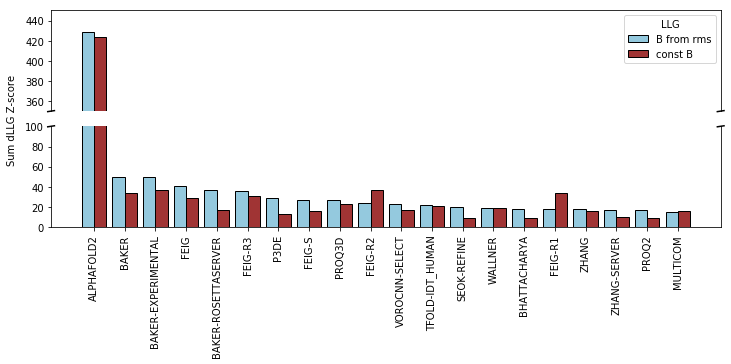

In [43]:
# make_group_rankings_barplots(df_1st, topn=20, target_parameters=[i for i in target_parameters if 'Original' not in i], label = '#1')
# make_group_rankings_barplots(df_1st, topn=20, target_parameters=[i for i in target_parameters if 'Original' not in i], label = '#1', mode = 'Mean')
make_group_rankings_barplots(df_1st, topn=20, target_parameters=[i for i in target_parameters if 'Original' not in i], label = '#1', mode = 'Sum')

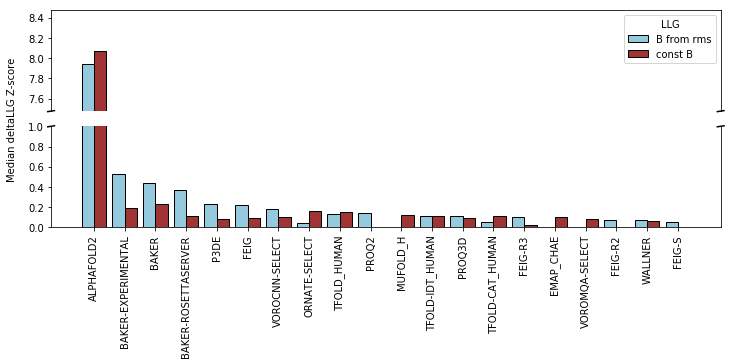

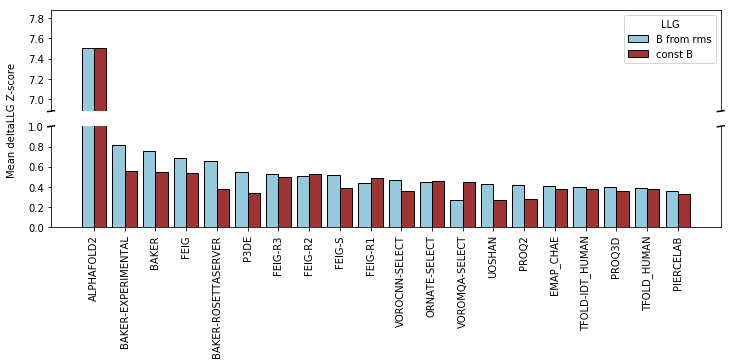

In [152]:
# make_group_rankings_barplots(df_mr, topn=20, target_parameters=[i for i in target_parameters if 'Original' not in i], label = '#1-#5')
# make_group_rankings_barplots(df_mr, topn=20, target_parameters=[i for i in target_parameters if 'Original' not in i], label = '#1-#5', mode = 'Mean')